*from https://www.kaggle.com/c/titanic*

**Group project from the Purple Power Rangers (#sg_prpl_power_rangers): Elena Greblova (@Elena), Elena Kutanov (@Elena Kutanov), and Eileen Hertwig (@Eileen)**

# Introduction to the Project

In our study group, we are all beginners when in comes to Deep Learning and none of us have entered in a kaggle competition before. 
The purpose of our study group was to find beginner friedly kaggle projects to get some hands-on experience with Deep Learning and also to get to know kaggle competitions. 

The Titanic competition is the classic first step when starting out at kaggle and a good intro to Machine Learning. That is why we chose it as our first project. 

At first each of us worked through a manual (*https://www.kaggle.com/sashr07/kaggle-titanic-tutorial*) which gives a good overview on how to prepare the data, train a model and submit the results to kaggle. 
The next step was to set-up our own model using **PyTorch** and trying to get the best predictions possible. 

Our journey with the Titanic project is documented in the following. 

# Following the manual
At first we will have a short summary of the manual, at least the points that we used as starting points for our own models. 

## Preparing the Data
A lot of the data preparation process could be taken from the manual, but because we wanted to use PyTorch we had to make some changes. 

In [1]:
#loading the libraries and looking at the training and testing data
import pandas as pd
import torch as th
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.simplefilter('ignore')

test = pd.read_csv("test.csv")
test_shape = test.shape
print(test_shape)

train = pd.read_csv("train.csv")
train_shape = train.shape
print(train_shape)

(418, 11)
(891, 12)


In [2]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### train.csv and test.csv:
Both training and testing data contain information about the passengers, but the information about survival is missing in the test data. The test data is for submission to kaggle. For model evaluation we will need to split our training data later on. 

## Which columns might be important to predict survival?
From what we know about the Titanic disaster sex, age, and class were probably important factors to decide who survived. In the following we will look at these columns. 

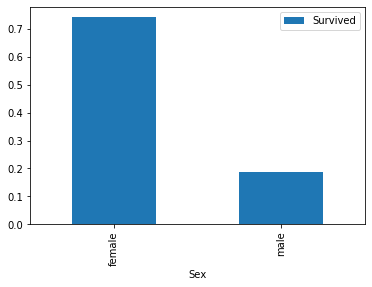

In [4]:
sex_pivot = train.pivot_table(index="Sex",values="Survived")
sex_pivot

sex_pivot.plot.bar()
plt.show()

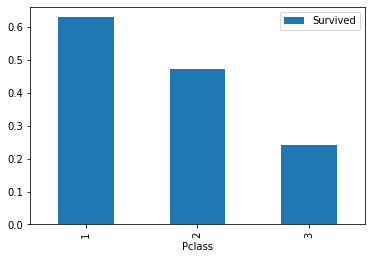

In [5]:
pclass_pivot = train.pivot_table(index="Pclass",values="Survived")
pclass_pivot.plot.bar()
plt.show()

In [6]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

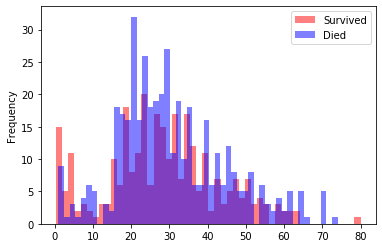

In [7]:
survived = train[train["Survived"] == 1]
died = train[train["Survived"] == 0]
survived["Age"].plot.hist(alpha=0.5,color='red',bins=50)
died["Age"].plot.hist(alpha=0.5,color='blue',bins=50)
plt.legend(['Survived','Died'])
plt.show()

For the age column it is more convenient to work with categories. The following function will cut the age column into 6 age ranges plus a category for missing values. 

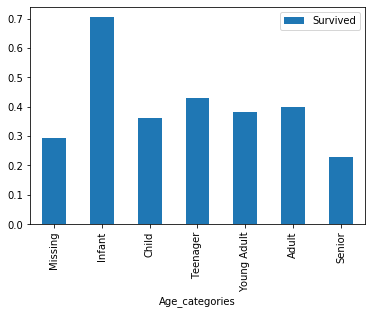

In [8]:
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

cut_points = [-1,0, 5, 12, 18, 35, 60, 100]
label_names = ["Missing", 'Infant', "Child", 'Teenager', "Young Adult", 'Adult', 'Senior']

train = process_age(train,cut_points,label_names)
test = process_age(test,cut_points,label_names)

age_cat_pivot = train.pivot_table(index="Age_categories",values="Survived")
age_cat_pivot.plot.bar()
plt.show()

## Dummy columns
For the model we need dummy columns representing sex, age categories, and class. 

In [9]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [10]:
train = create_dummies(train,"Pclass")
test = create_dummies(test,"Pclass")
train = create_dummies(train,"Sex")
test = create_dummies(test,"Sex")
train = create_dummies(train,"Age_categories")
test = create_dummies(test,"Age_categories")

In [11]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Pclass_3,Sex_female,Sex_male,Age_categories_Missing,Age_categories_Infant,Age_categories_Child,Age_categories_Teenager,Age_categories_Young Adult,Age_categories_Adult,Age_categories_Senior
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,1,0,1,0,0,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,0,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,1,0,0,0,0,0,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,0,0,0,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,1,0,1,0,0,0,0,1,0,0


In [12]:
# The following columns will enter our model to predict survival onboard the Titanic:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

In [13]:
columns

['Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Sex_female',
 'Sex_male',
 'Age_categories_Missing',
 'Age_categories_Infant',
 'Age_categories_Child',
 'Age_categories_Teenager',
 'Age_categories_Young Adult',
 'Age_categories_Adult',
 'Age_categories_Senior']

## Splitting the Training Data
To have some validation for our model we need to split the training data into training and test (what was called _test_ before, will now be called _holdout_). To get reproducible results, we set a `random_state = 30`. 

In [14]:
holdout = test # from now on we will refer to this dataframe as the holdout data

from sklearn.model_selection import train_test_split

columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

all_X = train[columns]
all_y = train['Survived']

train_X, test_X, train_y, test_y = train_test_split(all_X, all_y, test_size=0.2, random_state = 30)

In [15]:
train_X.shape

(712, 12)

In [16]:
all_X.shape

(891, 12)

## The Model (from the Manual)
We will now show the model from the manual, to have something to compare our results to. 

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# setting the seed for reproducibility:
#np.random.seed(30)

lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)
accuracy = accuracy_score(test_y, predictions)
accuracy *100.

79.3296089385475

### Accuracy:
The logistic regression model from _sklearn_ gives us an **accuracy of 79.3%**. 

# Logistic Regression with PyTorch

As a first try we will build a logistic regression model just as in the manual but based on PyTorch

## Data Preparation
Mostly we can use what we already have, but we decided to devide the age column more categories. 

In [18]:
def process_table(db):
    cut_points = [-1,0, 1, 4, 6, 12, 18, 28, 45, 60, 100]
    label_names = ["Missing", 'Infant', 'Baby', 'Toddler', "Child", 'Teenager', "Young Adult", 'Adult',
                   'Older Adult', 'Senior']
    # process age column
    db = process_age(db,cut_points,label_names)
    db = create_dummies(db, "Age_categories")
    #process sex column
    db = create_dummies(db, 'Sex')
    #process class column
    db = create_dummies(db,"Pclass")
    
    columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
               'Age_categories_Missing','Age_categories_Infant',
               'Age_categories_Baby', 'Age_categories_Toddler',
               'Age_categories_Child', 'Age_categories_Teenager',
               'Age_categories_Young Adult', 'Age_categories_Adult',
               'Age_categories_Older Adult','Age_categories_Senior']
    return db[columns]

In [19]:
#reload training data and create necessary dummy columns:
train = pd.read_csv("train.csv")
data = process_table(train)
labels = train['Survived']

### Splitting the training data into train and test data
Just as before, but because of the new age categories we need to do this again. 

In [20]:
train_X, test_X, train_y, test_y = train_test_split(data, labels, test_size=0.2, random_state = 30)

### Convert to torch tensors
Our input and label data needs to be converted to torch tensors. 

In [21]:
trainX = th.tensor(train_X.values)

In [22]:
trainX.shape

torch.Size([712, 15])

In [23]:
testX = th.tensor(test_X.values)
trainY = th.tensor(train_y.values)
testY = th.tensor(test_y.values)

## Define and Train the Model

In [24]:
#import libraries
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable

# setting the seed for reproducibility:
th.manual_seed(30)

In [25]:
# Create Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        out = self.linear(x)
        return out
    
# Instantiate Model Class
input_dim = 15 # number of input columns
output_dim = 2  # survived or not

# create logistic regression model
model = LogisticRegressionModel(input_dim, output_dim)

# Cross Entropy Loss  
error = nn.CrossEntropyLoss()

# SGD Optimizer 
learning_rate = 0.001
optimizer = th.optim.SGD(model.parameters(), lr=learning_rate)

In [26]:
# Traning the Model
batch_size = 4
batches = 178
num_epochs = 25

loss_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i in range(batches):
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        start = i * batch_size
        end = start + batch_size
        outputs = model(trainX[start:end].float())
        
        # Calculate softmax and cross entropy loss
        loss = error(outputs, trainY[start:end].long())
        
        # Calculate gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Prediction
        with th.no_grad(): 
            model.eval()
            # Predict test dataset
            outputs = model(testX.float())
                
            # Get predictions from the maximum value
            outputs = th.max(outputs, 1)[1]
            accuracy = th.mean((outputs == testY.long()).float())
        model.train()
            
        # store loss
        loss_list.append(loss.data)
        
    print('epoch {}: Accuracy {:.2f}'.format(epoch+1,accuracy * 100.0))
    accuracy_list.append(accuracy)

epoch 1: Accuracy 60.34
epoch 2: Accuracy 60.34
epoch 3: Accuracy 60.34
epoch 4: Accuracy 60.34
epoch 5: Accuracy 60.34
epoch 6: Accuracy 60.34
epoch 7: Accuracy 60.34
epoch 8: Accuracy 60.34
epoch 9: Accuracy 60.34
epoch 10: Accuracy 60.34
epoch 11: Accuracy 67.04
epoch 12: Accuracy 70.39
epoch 13: Accuracy 70.39
epoch 14: Accuracy 79.33
epoch 15: Accuracy 79.33
epoch 16: Accuracy 79.33
epoch 17: Accuracy 79.33
epoch 18: Accuracy 79.33
epoch 19: Accuracy 79.33
epoch 20: Accuracy 79.33
epoch 21: Accuracy 79.33
epoch 22: Accuracy 79.33
epoch 23: Accuracy 79.33
epoch 24: Accuracy 79.33
epoch 25: Accuracy 79.33


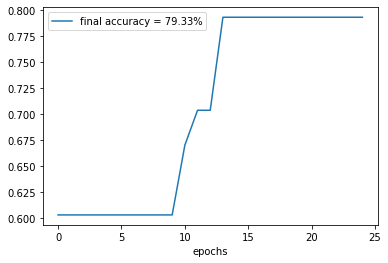

In [27]:
epochs = range(num_epochs)
plt.plot(epochs,accuracy_list)
plt.legend(['final accuracy = {:.2f}%'.format(np.mean(accuracy_list[-10:-1]) * 100.0)])
plt.xlabel('epochs');

With this model we get an **accuracy of 79.3%**, so just as in the model from the manual. 

# Deep Learning Model
As a next step we employ a deep learning model with 2 fully connected layers. For the most part we can keep the data preparation process as before. 

## Preparing the Data
### Splitting the Data into Training and Testing Data
As before and converting it directly into torch tensors:

In [28]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2,random_state=30)
train_data, test_data, train_labels, test_labels = th.Tensor(train_data.values), th.Tensor(test_data.values), th.Tensor(train_labels.values), th.Tensor(test_labels.values)

## Defining and Training the Model

In [29]:
import torch.nn.functional as F

# setting the seed for reproducibility:
th.manual_seed(30)

class Net(nn.Module):
    def __init__(self, hidden_number):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(15, 45)
        self.fc2 = nn.Linear(45, 1)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [30]:
hidden_number = 45
epoches = 500
batch_size = 89
batches = 8
model = Net(hidden_number)
criterion = nn.BCEWithLogitsLoss()
optimizer = th.optim.Adam(model.parameters(), lr=0.001)  

accuracy_list = []

for epoch in range(epoches):
    for i in range(batches):
        optimizer.zero_grad()
        start = i * batch_size
        end = start + batch_size
        output = model(train_data[start:end])
        loss = criterion(output, train_labels[start:end].view(-1, 1))
        loss.backward()
        optimizer.step()
    with th.no_grad():
        model.eval()
        output = th.exp(model(test_data))
        output = (output > 0.5).long()
        accuracy = th.mean((output == test_labels.view(-1, 1).long()).float())
        accuracy_list.append(accuracy)
    if (epoch % 10 == 0): 
        print('epoch {}: Accuracy {:.2f}'.format(epoch,accuracy * 100.0))
    model.train()


epoch 0: Accuracy 39.66
epoch 10: Accuracy 39.66
epoch 20: Accuracy 63.69
epoch 30: Accuracy 65.36
epoch 40: Accuracy 70.95
epoch 50: Accuracy 73.74
epoch 60: Accuracy 73.74
epoch 70: Accuracy 73.74
epoch 80: Accuracy 72.63
epoch 90: Accuracy 73.18
epoch 100: Accuracy 73.18
epoch 110: Accuracy 73.18
epoch 120: Accuracy 73.18
epoch 130: Accuracy 73.18
epoch 140: Accuracy 73.18
epoch 150: Accuracy 73.18
epoch 160: Accuracy 73.18
epoch 170: Accuracy 73.18
epoch 180: Accuracy 73.18
epoch 190: Accuracy 73.18
epoch 200: Accuracy 73.18
epoch 210: Accuracy 73.18
epoch 220: Accuracy 73.18
epoch 230: Accuracy 73.18
epoch 240: Accuracy 73.18
epoch 250: Accuracy 73.18
epoch 260: Accuracy 73.18
epoch 270: Accuracy 73.18
epoch 280: Accuracy 73.18
epoch 290: Accuracy 73.18
epoch 300: Accuracy 73.18
epoch 310: Accuracy 72.63
epoch 320: Accuracy 73.18
epoch 330: Accuracy 72.63
epoch 340: Accuracy 73.18
epoch 350: Accuracy 72.63
epoch 360: Accuracy 72.63
epoch 370: Accuracy 72.63
epoch 380: Accuracy 72.

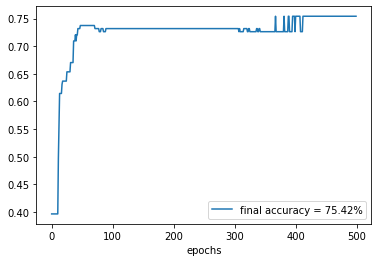

In [31]:
eps = range(epoches)
plt.plot(eps,accuracy_list)
plt.legend(['final accuracy = {:.2f}%'.format(np.mean(accuracy_list[-10:-1]) * 100.0)])
plt.xlabel('epochs');

### Accuracy:
This model yields an **accuracy score of 75.4%**, so slightly less than the logistic regression models. We will try one more model, where we adjust the age categories back to the same state as in the manual (just 6). 

# Deep Learning Model With Less Age Categories

## Data Preparation 
As before, but with less age categories:

In [32]:
train = pd.read_csv('train.csv')
def process_age(df,cut_points,label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

cut_points = [-1,0, 5, 12, 18, 35, 60, 100]
label_names = ["Missing", 'Infant', "Child", 'Teenager', "Young Adult", 'Adult', 'Senior']

train = process_age(train, cut_points, label_names)

In [33]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

def prepare_data(data):
    data = create_dummies(data,"Pclass")
    data = create_dummies(data,"Sex")
    data = create_dummies(data,"Age_categories")
    
    return data

In [34]:
columns = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'Age_categories_Missing','Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior']

In [35]:
train = prepare_data(train)
print('train.shape:', train.shape)

train.shape: (891, 25)


### Splitting the Data in to Training and Testing Data

In [36]:
all_X = train[columns]
all_y = train['Survived']

train_X, test_X, train_Y, test_Y = train_test_split(all_X, all_y, test_size=0.2, random_state=30)

### Convert to PyTorch

In [37]:
print('---> train_X:', train_X.shape)
print('---> train_Y:', train_Y.shape)
print('---> test_X:', test_X.shape)
print('---> test_Y:', test_Y.shape)

train_X_t = th.tensor(train_X.values)
train_Y_t = th.tensor(train_Y.values)

test_X_t  = th.tensor(test_X.values)
test_Y_t  = th.tensor(test_Y.values)

---> train_X: (712, 12)
---> train_Y: (712,)
---> test_X: (179, 12)
---> test_Y: (179,)


## Define and Train the Model

In [38]:
# *********** Create the model **********
#from torch import nn
from collections import OrderedDict

# setting the seed for reproducibility:
th.manual_seed(30)

model = nn.Sequential(OrderedDict([
    ('fc1',  nn.Linear(12, 4)),
    ('relu', nn.ReLU()),
    ('drop', nn.Dropout(p=0.2)),
    ('fc2',  nn.Linear(4, 2)),
    ('output', nn.Softmax(dim=1))
]))

In [39]:
def model_learning(obj_model, obj_opt, obj_data, obj_target):
    obj_opt.zero_grad()
    
    obj_pred = obj_model(obj_data.float())
    obj_loss = criterion(obj_pred, obj_target.long())
    obj_loss.backward()
    
    obj_opt.step()

    return obj_loss

In [40]:
epochs = 200
train_sets_num = 89
train_set_size = 8

# setting the seed for reproducibility:
th.manual_seed(30)

loss = th.FloatTensor
criterion = nn.CrossEntropyLoss()
opt = th.optim.Adam(model.parameters(), lr=0.01)

accuracy_list = []

for e in range(epochs):
    running_loss = 0
    for ts_i in range(0, train_sets_num, train_set_size):
        running_loss += model_learning(model, opt,
                                      train_X_t[ts_i: ts_i+train_set_size],
                                      train_Y_t[ts_i: ts_i+train_set_size ]).item()
    else: 
        with th.no_grad():
            model.eval()
            test_loss = 0
            accuracy  = 0

            pred = model(test_X_t.float())
            loss = criterion(pred, test_Y_t.long())
            test_loss += loss.item()

            output = th.max(pred, 1)[1]
            accuracy = th.mean((output == test_Y_t.long()).float())
            accuracy_list.append(accuracy)

    if (e % 10 == 0): 
        print('epoch {}: Accuracy {:.2f}'.format(e,accuracy * 100.0))
            
        model.train()

epoch 0: Accuracy 69.27
epoch 10: Accuracy 75.42
epoch 20: Accuracy 77.65
epoch 30: Accuracy 77.65
epoch 40: Accuracy 77.65
epoch 50: Accuracy 77.65
epoch 60: Accuracy 77.65
epoch 70: Accuracy 77.65
epoch 80: Accuracy 77.65
epoch 90: Accuracy 77.65
epoch 100: Accuracy 77.65
epoch 110: Accuracy 77.65
epoch 120: Accuracy 77.65
epoch 130: Accuracy 77.65
epoch 140: Accuracy 77.65
epoch 150: Accuracy 77.65
epoch 160: Accuracy 77.65
epoch 170: Accuracy 77.65
epoch 180: Accuracy 77.65
epoch 190: Accuracy 77.65


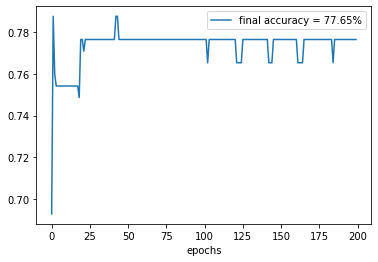

In [41]:
eps = range(epochs)
plt.plot(eps,accuracy_list)
plt.legend(['final accuracy = {:.2f}%'.format(np.mean(accuracy_list[-10:-1]) * 100.0)])
plt.xlabel('epochs');

### Accuracy:
With this model we get an **accuracy of 77.7%**. 

# Conclusion

We have employed three different models to predict survival onboard the Titanic. For that we have considered the sex, the class and the age of the passengers. The age has been divided into categories, but the numbers of categories does not seem to influence the result much since both logistic regression models yield the same result (accuracy of 79.3%). The other two models get very similar results for the accuracy (75.4% and 77.7%). 

It has to be noted, however, that we set the seed for reproducible results both when dividing the data into training and testing data and when training the model. A different seed would have led to different results. In the manual cross-validation is mentioned as a method to get more robust results. 

We have trained all three models with the full training data set and made predictions on the test set. We do not have a survival column for `test.csv`, therefore we had to submit it to kaggle.com to find out the performance of our models. They were all similar to the accuracy that we found here (close to 80%), so what we show here seems to be representable for the overall performance of our models. 